# Preprocessing

## Preparation

### Loading libraries

In [2]:
import mne
import os
import re
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from mne.channels import make_standard_montage

### Initializing data and event files

In [3]:
dir_address = "../grasp-and-lift-eeg-detection"

# Training data
training_files = os.listdir(f"{dir_address}/train") # subj1_series1_data.csv
# Subsetting training files
training_files_events = [file for file in training_files if re.search("events",file)]
training_files_data = [file for file in training_files if re.search("data",file)]

# Testing data 
testing_files = os.listdir(f"{dir_address}/test")
# Subsetting testing files
testing_files_events = [file for file in testing_files if re.search("events",file)]
testing_files_data = [file for file in testing_files if re.search("data",file)]

Creating RawArray with float64 data, n_channels=32, n_times=149945
    Range : 0 ... 149944 =      0.000 ...   299.888 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=149945
    Range : 0 ... 149944 =      0.000 ...   299.888 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=149945
    Range : 0 ... 149944 =      0.000 ...   299.888 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=149945
    Range : 0 ... 149944 =      0.000 ...   299.888 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=149945
    Range : 0 ... 149944 =      0.000 ...   299.888 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=149945
    Range : 0 ... 149944 =      0.000 ...   299.888 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=149945
    Range : 0 ... 149944 =      0.000 ...   299.888 secs
Ready.


<Figure size 432x288 with 0 Axes>

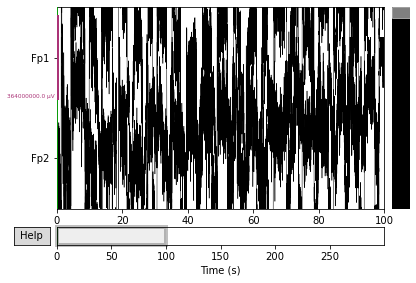

In [6]:
def get_subject_files(subject,dir_address,test=False,series=None):
    '''
    dir_address: refers to the folder which contains the training and testing subfolders
    subject: refers to the subject number to return
    test: refers to whether you want training or testing data
            If no opton is given, then the training files are automatically chosen
    series: refers to the specific series that you want to access
            If no series is given, returns all subject files
    '''
    if test:
        subfolder = "test"
    else:
        subfolder = "train"
    files = os.listdir(f"{dir_address}/{subfolder}")
    data  = np.sort([file for file in files if re.search(f"subj{subject}_",file) and re.search(f"data",file)]).tolist()
    events = np.sort([file for file in files if re.search(f"subj{subject}_",file) and re.search(f"event",file)]).tolist()
    if series:
        data = [file for file in data if re.search(f"_series{series}_",file)]
        events = [file for file in events if re.search(f"_series{series}_",file)]

    return data, events

def create_raw(datafile,dir_address,test=False,sfreq=500):
    '''
    datafile: refers to the address of the file you are trying to access
    dir_address: refers to the address of the directory you are trying to access (directory contains file)
    test: if True, returns testing files, else looks for training files
    sfreq: refers to the sampling frequency, if none given, 500 Hz
    '''
    if test:
        subfolder = "test"
    else:
        subfolder = "train"
    file_address = f"{dir_address}/{subfolder}/{datafile}"
    chnames = pd.read_csv(f"{dir_address}/{subfolder}/{datafile}").columns[1:].to_list()
    info = mne.create_info(chnames,sfreq,ch_types=['eeg']*len(chnames))
    samples = np.genfromtxt(file_address,delimiter=",")[1:,1:].T
    raw = mne.io.RawArray(samples,info)
    return raw, chnames

def add_events(raw,event,dir_address,test=False):
    '''
    raw: raw object from mne tools
    event: the event file to add events from
    dir_address: the directory from which to obtain the event
    test: if False, returns training files. If True, returns testing files.
    '''
    if test:
        subfolder = "test"
    else:
        subfolder = "train"
    event_names = pd.read_csv(f"{dir_address}/train/{event}").columns[1:].to_list()
    samples = np.genfromtxt(f"{dir_address}/{subfolder}/{event}",delimiter=",")[1:,1:].T
    num_events = samples.shape[0]
    for i in range(num_events):
        event_data = 1e-6*samples[i]
        sample_numbers = list(range(0,len(event_data)))
        event_name = event_names[i][0:15]
        event_samples = np.vstack((sample_numbers,[np.random.randint(100) for i in range(len(sample_numbers))],event_data)).T
        info = mne.create_info([event_name], raw.info['sfreq'], ['stim'])
        stim_data = np.zeros((1, raw.n_times))
        stim_raw = mne.io.RawArray(stim_data, info)
        raw.add_channels([stim_raw], force_update_info=True)
        raw.add_events(events=event_samples,stim_channel = event_name)
    return list(map(lambda x: x[0:15],event_names))

data, events = get_subject_files(2,dir_address,series=8)
raw ,ch_names= create_raw(data[0],dir_address) # example 
event_names = add_events(raw,events[0],dir_address)
scalings = 'auto'  # Could also pass a dictionary with some value == 'auto'
# raw = raw.set_eeg_reference()

# montage = make_standard_montage('standard_1005')
# raw.set_montage(montage)
events_mne = mne.find_events(raw, stim_channel=event_names)
plt.figure()
raw.plot(events=events_mne,n_channels=2,duration=100,scalings=scalings,verbose=False); plt.show()


In [7]:
events

['subj2_series8_events.csv']

In [60]:
df = raw.to_data_frame()

In [68]:
df["Fp1"].mean()*1e-6

109.27855547033911

In [48]:
raw.info

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, T7, C3, Cz, ...
 chs: 32 EEG, 6 STIM
 custom_ref_applied: False
 dig: 0 items
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 38
 projs: []
 sfreq: 500.0 Hz
>

## Spectral Content Analysis

Effective window size : 4.096 (s)


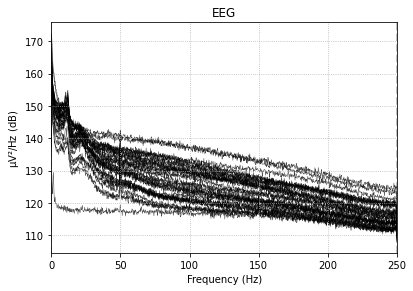

In [5]:
raw = raw.pick_types(meg=False, eeg=True, eog=False)
raw.plot_psd(spatial_colors=False)
plt.show()

### Making Montage

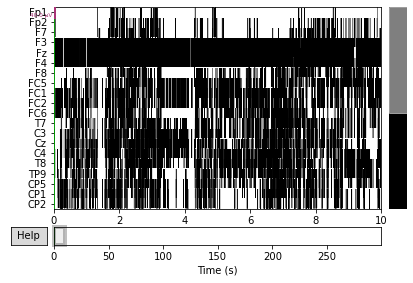

In [36]:
montage = make_standard_montage('standard_1005')
raw.set_montage(montage)
raw.plot()
plt.show()

## Topographical Analysis (after identifying bad channels)

In [4]:
from scipy.signal import butter

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.


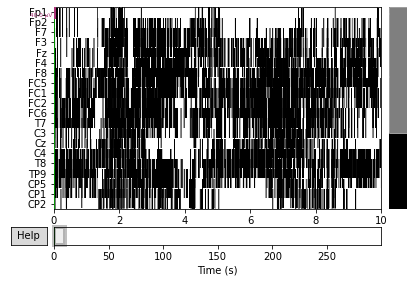

Effective window size : 0.600 (s)


In [10]:
from mne.time_frequency import psd_welch
raw = raw.pick_types(meg=False, eeg=True, eog=False)
raw = raw.set_eeg_reference()
raw.plot()
spectra, freqs = psd_welch(raw, fmin=1, fmax=40, tmin=0, tmax=250,
                           n_overlap=150, n_fft=300)